# Loading Model and Testing

In [27]:
! ls

Base_transformer.ipynb	Base_transformer.py  __pycache__  play_loader.py


In [28]:
import sys
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from importlib import reload

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)     # <-- the file we made

In [29]:
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
#WEIGHT_PATTERN = "weights/epoch_{:03d}-val{:.4f}.weights.h5"

WEIGHT_FILE = "../../weights/epoch_006-val0.004148.weights.h5"   # adjust as needed

model = TransformerPredictor(dtype_policy="mixed_float16")  # or omit arg for fp32
#model = TransformerPredictor()
model.load_weights(WEIGHT_FILE)

model.summary()  # sanity-check layer names/shapes match the notebook

Model: "NFL_Frame_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_22 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_xy (Dense)     │ (None, 100, 128)  │      6,016 │ cast_22[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_23 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_enc             │ (None, 100, 128)  │     12,800 │ proj_xy[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pad_mask            │ (None, 1, 1, 100) │          0 │ cast_23[0][0]     │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 100, 128)  │    198,272 │ pos_enc[0][0],    │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 100, 128)  │    198,272 │ functional_8[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_10       │ (None, 100, 128)  │    198,272 │ functional_9[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, 100, 128)  │    198,272 │ functional_10[0]… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_last_hidden  │ (None, 128)       │          0 │ functional_11[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_32 (Cast)      │ (None, 128)       │          0 │ lambda_last_hidd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy (Dense)     │ (None, 46)        │      5,934 │ cast_32[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 817,838 (3.12 MB)

 Trainable params: 817,838 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
"""batch_size   = 8
timesteps_in = 80                    # < MAX_LEN just for demo
dummy_seq_batch = tf.random.uniform([batch_size, timesteps_in, 46])
dummy_seq = tf.random.uniform([timesteps_in, 46])"""

'batch_size   = 8\ntimesteps_in = 80                    # < MAX_LEN just for demo\ndummy_seq_batch = tf.random.uniform([batch_size, timesteps_in, 46])\ndummy_seq = tf.random.uniform([timesteps_in, 46])'

In [32]:
"""y_next = model.predict_next(dummy_seq)      # (8, 46)
print("Next-frame prediction shape:", y_next.shape)"""

'y_next = model.predict_next(dummy_seq)      # (8, 46)\nprint("Next-frame prediction shape:", y_next.shape)'

In [33]:
"""n_future = 10
y_future = model.predict_autoregressive(dummy_seq, n_steps=n_future)  # (8, 10, 46)
print("Autoregressive rollout shape:", y_future.shape)"""

'n_future = 10\ny_future = model.predict_autoregressive(dummy_seq, n_steps=n_future)  # (8, 10, 46)\nprint("Autoregressive rollout shape:", y_future.shape)'

# Vissualizing

In [34]:
"""DATASET_PATH = "../../processed_data/transformer_dataset_9"

def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

def drop_meta(meta, x, y):
    return x, y

raw_ds = tf.data.Dataset.load(DATASET_PATH)

test_ds  = (raw_ds
            .filter(filter_split(2))
            .shuffle(4096)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE))"""



'DATASET_PATH = "../../processed_data/transformer_dataset_9"\n\ndef filter_split(split_num):\n    def _filter(meta, x, y):\n        return tf.equal(meta[2], split_num)\n    return _filter\n\ndef drop_meta(meta, x, y):\n    return x, y\n\nraw_ds = tf.data.Dataset.load(DATASET_PATH)\n\ntest_ds  = (raw_ds\n            .filter(filter_split(2))\n            .shuffle(4096)\n            .batch(1)\n            .prefetch(tf.data.AUTOTUNE))'

In [35]:
"""play = next(iter(test_ds))            # a single batch (meta, x, y)

meta, x_ctx, y_next = play            # x_ctx: (1,100,46)"""

'play = next(iter(test_ds))            # a single batch (meta, x, y)\n\nmeta, x_ctx, y_next = play            # x_ctx: (1,100,46)'

In [36]:
"""n_future = 40
y_future = model.predict_autoregressive(x_ctx, n_steps=n_future)  # (1,100,46)

print("context shape:", x_ctx.shape)
print("future   shape:", y_future.shape)"""

'n_future = 40\ny_future = model.predict_autoregressive(x_ctx, n_steps=n_future)  # (1,100,46)\n\nprint("context shape:", x_ctx.shape)\nprint("future   shape:", y_future.shape)'

In [37]:
"""full_pred = tf.concat([x_ctx, y_future], axis=1)      # (1,200,46)
ground_truth_seq = None            # ← replace when available"""

'full_pred = tf.concat([x_ctx, y_future], axis=1)      # (1,200,46)\nground_truth_seq = None            # ← replace when available'

In [38]:
"""_ = plot_trajectories(
        sequence=x_ctx[0],                 # solid lines:   100-frame context
        offense='all', defense='all', include_ball=True,
        ground_truth_seq=(ground_truth_seq[:, 100:] if ground_truth_seq is not None else None),
        pred_seq=full_pred[:, 100:],       # dashed lines: model rollout
        gt_linestyle='-.', pred_linestyle='--',
        gt_color='limegreen', pred_color='crimson')"""

"_ = plot_trajectories(\n        sequence=x_ctx[0],                 # solid lines:   100-frame context\n        offense='all', defense='all', include_ball=True,\n        ground_truth_seq=(ground_truth_seq[:, 100:] if ground_truth_seq is not None else None),\n        pred_seq=full_pred[:, 100:],       # dashed lines: model rollout\n        gt_linestyle='-.', pred_linestyle='--',\n        gt_color='limegreen', pred_color='crimson')"

In [39]:
from play_loader import load_play

In [40]:
import polars as pl

In [41]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")

"""df = pd.read_parquet("../../processed_data/model_input_9.parquet")
df = df.merge(game_indexer, how="left", on=["gameId", "playId"])"""

'df = pd.read_parquet("../../processed_data/model_input_9.parquet")\ndf = df.merge(game_indexer, how="left", on=["gameId", "playId"])'

Selected gameId = 2022092513, playId = 3504
/mnt/c/Users/sebas/Desktop/LSE_2.0/MSc Statistics/ST456 Deep Learning/2025-projects-shallowlearning/code/Models


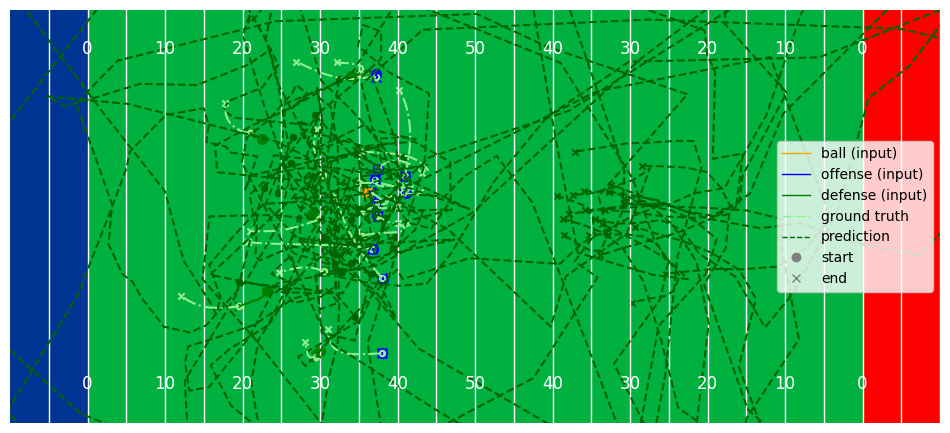

In [42]:
# Filter to test rows and pick one at random
N_STEPS = 30

row = (
    game_indexer
    .loc[game_indexer['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_9.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = model.predict_autoregressive(context_seq, n_steps=N_STEPS)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense='all', include_ball=True)